# Analyzing News Articles by Kunal Vaishnavi

In [1]:
import json
import string

import numpy as np
import pandas as pd
import requests

import nltk

Initially, I was unable to load the CSV. This was because after examining the original [dataset](https://www.kaggle.com/asad1m9a9h6mood/news-articles/data), I noticed that the dataset had weird symbols for apostrophes. So, I opened the CSV in Atom and replaced all of the weird symbols with an apostrophe. Then, I loaded it again.

In [ ]:
df = pd.read_csv("articles.csv")

Now that it worked, I wanted to remove any rows that are in 2017. This was because I wanted to display my visualization over a year and 2017 was not complete (we're still living in it). I also wanted to drop the news type column because it was unnecessary for me.

So, I manually located where '1/1/2017' was (index = 2575) and removed all rows from that index to the end. Then, I dropped the 'NewsType' column. I will save this edited CSV as a new file.

In [ ]:
df = df.drop(df.index[2575:])
df = df.drop('NewsType', axis=1)

Then, I noticed that many rows had yet to be cleaned by the owner of the dataset. So, first I stripped any "\r" and "\n" in each row.

In [ ]:
df['Article'] = df['Article'].str.replace('\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n', '')
df['Article'].head()

But I opened the file in Atom and realized that it's not fully cleaned. I noticed that it had been scraped from a website, so the HTML tags were still in it. I googled a tool that I could use to quickly do this process and I discovered [BeautifulSoup](https://stackoverflow.com/questions/32131901/best-way-to-clean-up-html-text). I used that to clean up the rows. There were edge cases here and there that I fixed using Atom's replaceAll feature.

In [ ]:
from bs4 import BeautifulSoup

for i, t in enumerate(df['Article']):
    soup = BeautifulSoup(t, 'lxml')
    temp = soup.text
    temp = temp.replace('strong>', '')
    temp = temp.replace('/>', '')
    temp = temp.replace('em>', '')
    df['Article'][i] = temp
df['Article'].head()
df.to_csv('articlesEdited.csv')

Finally, to make things easier to view, I merged all of the above code into one block.

In [ ]:
import json
import string
import numpy as np
import pandas as pd
import requests
import nltk
from bs4 import BeautifulSoup

# Format text in "Article" column
df = pd.read_csv("articles.csv")
df = df.drop(df.index[2575:])
df = df.drop('NewsType', axis=1)
df['Article'] = df['Article'].str.replace('\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n', '')
df['Article'].head()

for i, t in enumerate(df['Article']):
    soup = BeautifulSoup(t, 'lxml')
    temp = soup.text
    temp = temp.replace('strong>', '')
    temp = temp.replace('/>', '')
    temp = temp.replace('em>', '')
    # Figure out if there's a way to do temp = temp.replace() to the other random stuff that showed up
    df['Article'][i] = temp

# Save formatted columns to a new CSV
df.to_csv('articlesEdited.csv')

Now, I was able to load the CSV titled "articlesEdited.csv", as I had loaded the original CSV. An error came on a line, which had been messed up with the above code, so I manually fixed it in Excel, since that was an easier way for me to find and fix the error.

In [2]:
df = pd.read_csv("articlesEdited.csv", index_col=0)

Oddly, it kept saying that there were unnamed columns in my CSV. I googled this issue and the code from this [link](https://stackoverflow.com/questions/43983622/remove-unnamed-columns-in-pandas-dataframe) helped me remove those blank columns.

In [3]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

However, when I examined the articles in each row, I realized that the sentences weren't forming correctly. This would later cause a problem with tokenizing, as it relies upon the period and the space after it to split sentences apart. I googled a fast way to do this using regular expressions and found [one](https://stackoverflow.com/questions/6455557/python-regex-that-adds-space-after-dot/).

In [4]:
import re

for i, t in enumerate(df['Article']):
    t = t.replace(".", ". ")
#     t = re.sub(r'\.([a-zA-Z])', r'. \1', t)
    df['Article'][i] = t

Now that my data was properly formatted, I was now able to begin the natural language processing part. However, I remembered from the class on natural language processing that for some odd reason, I was unable to access the "corpora" menu. So, I googled how to download the two packages I needed from "corpora" and came across a simple [solution](https://stackoverflow.com/questions/6661108/import-wordnet-in-nltk).

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

Now that I was able to use the above two packages, I began the process of converting the words in my CSV to a dataset. To start this process, I first had to separate all of the articles into sentences, then separate those sentences into words, remove any punctuation that "appears" as a word, and then merge all of these words back together with the right grouping.

In [5]:
data = []
for t in df['Article']:
    temp = []
    sent_tokens = nltk.sent_tokenize(t) # Make a list of sentences for each article
    for w in sent_tokens:
        word_tokens = nltk.word_tokenize(w) # Make a list of words for each sentence
        word_tokens = [w.lower() for w in word_tokens]
        for i, word in enumerate(word_tokens): 
            if len(word) == 1 and word[0] in string.punctuation: # Remove punctuation in word_tokens list
                word_tokens.pop(i)
        temp.extend(word_tokens)
    data.append(temp)

Next, I removed any unnecessary words that won't help with the objective of this process. This is a combination of "stop words," numbers that "appear" as words, punctuation, etc.

In [6]:
from nltk.corpus import stopwords

for i, article in enumerate(data): # article is still a 1D list
    temp = []
    for word in article:
        if (word not in stopwords.words('english')) and (word.isdigit() == False) and (word not in string.punctuation): 
            temp.append(word)
    data[i] = temp

Now, I was ready to determine the sentiment of each of the words. I had a hunch that NLTK could do this so I googled a way to use NLTK for sentiment analysis and discovered this [link](http://www.nltk.org/_modules/nltk/corpus/reader/sentiwordnet.html), which showed me how I could use NLTK to achieve my goal. To do this, I first had to download the 'sentiwordnet' package.

In [ ]:
nltk.download('sentiwordnet')

In [7]:
from nltk.corpus import sentiwordnet as swn

scores = []
for arr in data:
    temp = []
    for word in arr:
        try:
            wordToAnalyze = list(swn.senti_synsets(word))[0]
            temp.append([wordToAnalyze.pos_score(), wordToAnalyze.neg_score(), wordToAnalyze.obj_score(), word])
        except:
            continue
    scores.append(temp)
posVsNeg = []
for article in scores:
    positive = 0
    negative = 0
    for nums in article:
        positive += nums[0]
        negative += nums[1]
    posVsNeg.append([positive, negative])

This part here where the words were given values based on their connotation could be more accurate. Currently, these values are based off of the standard values given by this library (which were obtained by training the algorithm). Two ways that this could be more accurate are:

a) Continuing to [train](http://www.nltk.org/howto/sentiment.html) the algorithm and then obtain the values.

b) Providing [accurate](http://www.nltk.org/book/ch05.html) parts of speech tags and figuring out how to use those tags in the above algorithm to generates more accurate values (because you get a slightly more accurate value if you put a part of speech tag as a parameter).

Finally, I needed to convert my list into a CSV file, using this [link](https://stackoverflow.com/questions/19575456/how-to-write-list-of-lists-in-csv-file-in-python) as a guide, along with the dates for each row.

In [8]:
import csv

with open("posNegVals.csv", "w") as p:
    wr = csv.writer(p)
    wr.writerow(['positive', 'negative', 'date'])
    for i, t in enumerate(df['Date']):
        wr.writerow([posVsNeg[i][0], posVsNeg[i][1], t])

Here is all of the above code cleaned up and merged into one block:

In [ ]:
import json
import string
import numpy as np
import pandas as pd
import requests
import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
import csv

# Load new CSV and remove empty columns
df = pd.read_csv("articlesEdited.csv", index_col=0)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Split by period. Though it is discouraged, in this project we don't care about how it affects abbreviations
# or how numbers get messed up. This is because we are just focused on the tone of words.
for i, t in enumerate(df['Article']):
    t = t.replace(".", ". ")
    df['Article'][i] = t

# Create a list with the list of words for every article
# Remove certain words that aren't needed
data = []
for t in df['Article']:
    temp = []
    sent_tokens = nltk.sent_tokenize(t) # Make a list of sentences for each article
    for w in sent_tokens:
        word_tokens = nltk.word_tokenize(w) # Make a list of words for each sentence
        word_tokens = [w.lower() for w in word_tokens]
        for i, word in enumerate(word_tokens): 
            if len(word) == 1 and word[0] in string.punctuation: # Remove punctuation in word_tokens list
                word_tokens.pop(i)
        temp.extend(word_tokens)
    data.append(temp)

# Continue removing certain words that aren't needed
for i, article in enumerate(data):
    temp = []
    for word in article:
        if (word not in stopwords.words('english')) and (word.isdigit() == False) and (word not in string.punctuation): 
            temp.append(word)
    data[i] = temp

# Create a list with the scores of +ve, -ve, and neutral tones for every word in the article
scores = []
for arr in data:
    temp = []
    for word in arr:
        try:
            wordToAnalyze = list(swn.senti_synsets(word))[0]
            temp.append([wordToAnalyze.pos_score(), wordToAnalyze.neg_score(), wordToAnalyze.obj_score(), word])
        except:
            continue
    scores.append(temp)

# Create a list with the sum of +ve and -ve scores for every article
posVsNeg = []
for article in scores:
    positive = 0
    negative = 0
    for nums in article:
        positive += nums[0]
        negative += nums[1]
    posVsNeg.append([positive, negative])

# Save the list to a CSV
with open("posNegVals.csv", "w") as p:
    wr = csv.writer(p)
    wr.writerow(['positive', 'negative', 'date'])
    for i, t in enumerate(df['Date']):
        wr.writerow([posVsNeg[i][0], posVsNeg[i][1], t])

And here is all the code in this file in one block:

In [ ]:
import json
import string
import numpy as np
import pandas as pd
import requests
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
import csv

# Format text in "Article" column
df = pd.read_csv("articles.csv")
df = df.drop(df.index[2575:])
df = df.drop('NewsType', axis=1)
df['Article'] = df['Article'].str.replace('\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n', '')
df['Article'].head()

for i, t in enumerate(df['Article']):
    soup = BeautifulSoup(t, 'lxml')
    temp = soup.text
    temp = temp.replace('strong>', '')
    temp = temp.replace('/>', '')
    temp = temp.replace('em>', '')
    # Figure out if there's a way to do temp = temp.replace() to the other random stuff that showed up
    df['Article'][i] = temp

# Save formatted columns to a new CSV
df.to_csv('articlesEdited.csv')

# Load new CSV and remove empty columns
df = pd.read_csv("articlesEdited.csv", index_col=0)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Split by period. Though it is discouraged, in this project we don't care about how it affects abbreviations
# or how numbers get messed up. This is because we are just focused on the tone of words.
for i, t in enumerate(df['Article']):
    t = t.replace(".", ". ")
    df['Article'][i] = t

# Create a list with the list of words for every article
# Remove certain words that aren't needed
data = []
for t in df['Article']:
    temp = []
    sent_tokens = nltk.sent_tokenize(t) # Make a list of sentences for each article
    for w in sent_tokens:
        word_tokens = nltk.word_tokenize(w) # Make a list of words for each sentence
        word_tokens = [w.lower() for w in word_tokens]
        for i, word in enumerate(word_tokens): 
            if len(word) == 1 and word[0] in string.punctuation: # Remove punctuation in word_tokens list
                word_tokens.pop(i)
        temp.extend(word_tokens)
    data.append(temp)

# Continue removing certain words that aren't needed
for i, article in enumerate(data):
    temp = []
    for word in article:
        if (word not in stopwords.words('english')) and (word.isdigit() == False) and (word not in string.punctuation): 
            temp.append(word)
    data[i] = temp

# Create a list with the scores of +ve, -ve, and neutral tones for every word in the article
scores = []
for arr in data:
    temp = []
    for word in arr:
        try:
            wordToAnalyze = list(swn.senti_synsets(word))[0]
            temp.append([wordToAnalyze.pos_score(), wordToAnalyze.neg_score(), wordToAnalyze.obj_score(), word])
        except:
            continue
    scores.append(temp)

# Create a list with the sum of +ve and -ve scores for every article
posVsNeg = []
for article in scores:
    positive = 0
    negative = 0
    for nums in article:
        positive += nums[0]
        negative += nums[1]
    posVsNeg.append([positive, negative])

# Save the list to a CSV
with open("posNegVals.csv", "w") as p:
    wr = csv.writer(p)
    wr.writerow(['positive', 'negative', 'date'])
    for i, t in enumerate(df['Date']):
        wr.writerow([posVsNeg[i][0], posVsNeg[i][1], t])

Now that I had my values, it was time to create my visualization. I first set up my axes but they came out weirdly. So, I googled a way to customize the labeling and this [link](https://bl.ocks.org/d3indepth/1aef77d17863e603ff4e84226db5b227) helped me do so. Then, I discovered another [link](https://stackoverflow.com/questions/40193057/shift-x-axis-to-arbitrary-position) to move the x axis up and a third [link](https://bl.ocks.org/biovisualize/9c0d30d0539914ecdb15) to put some padding around the x axis captions.

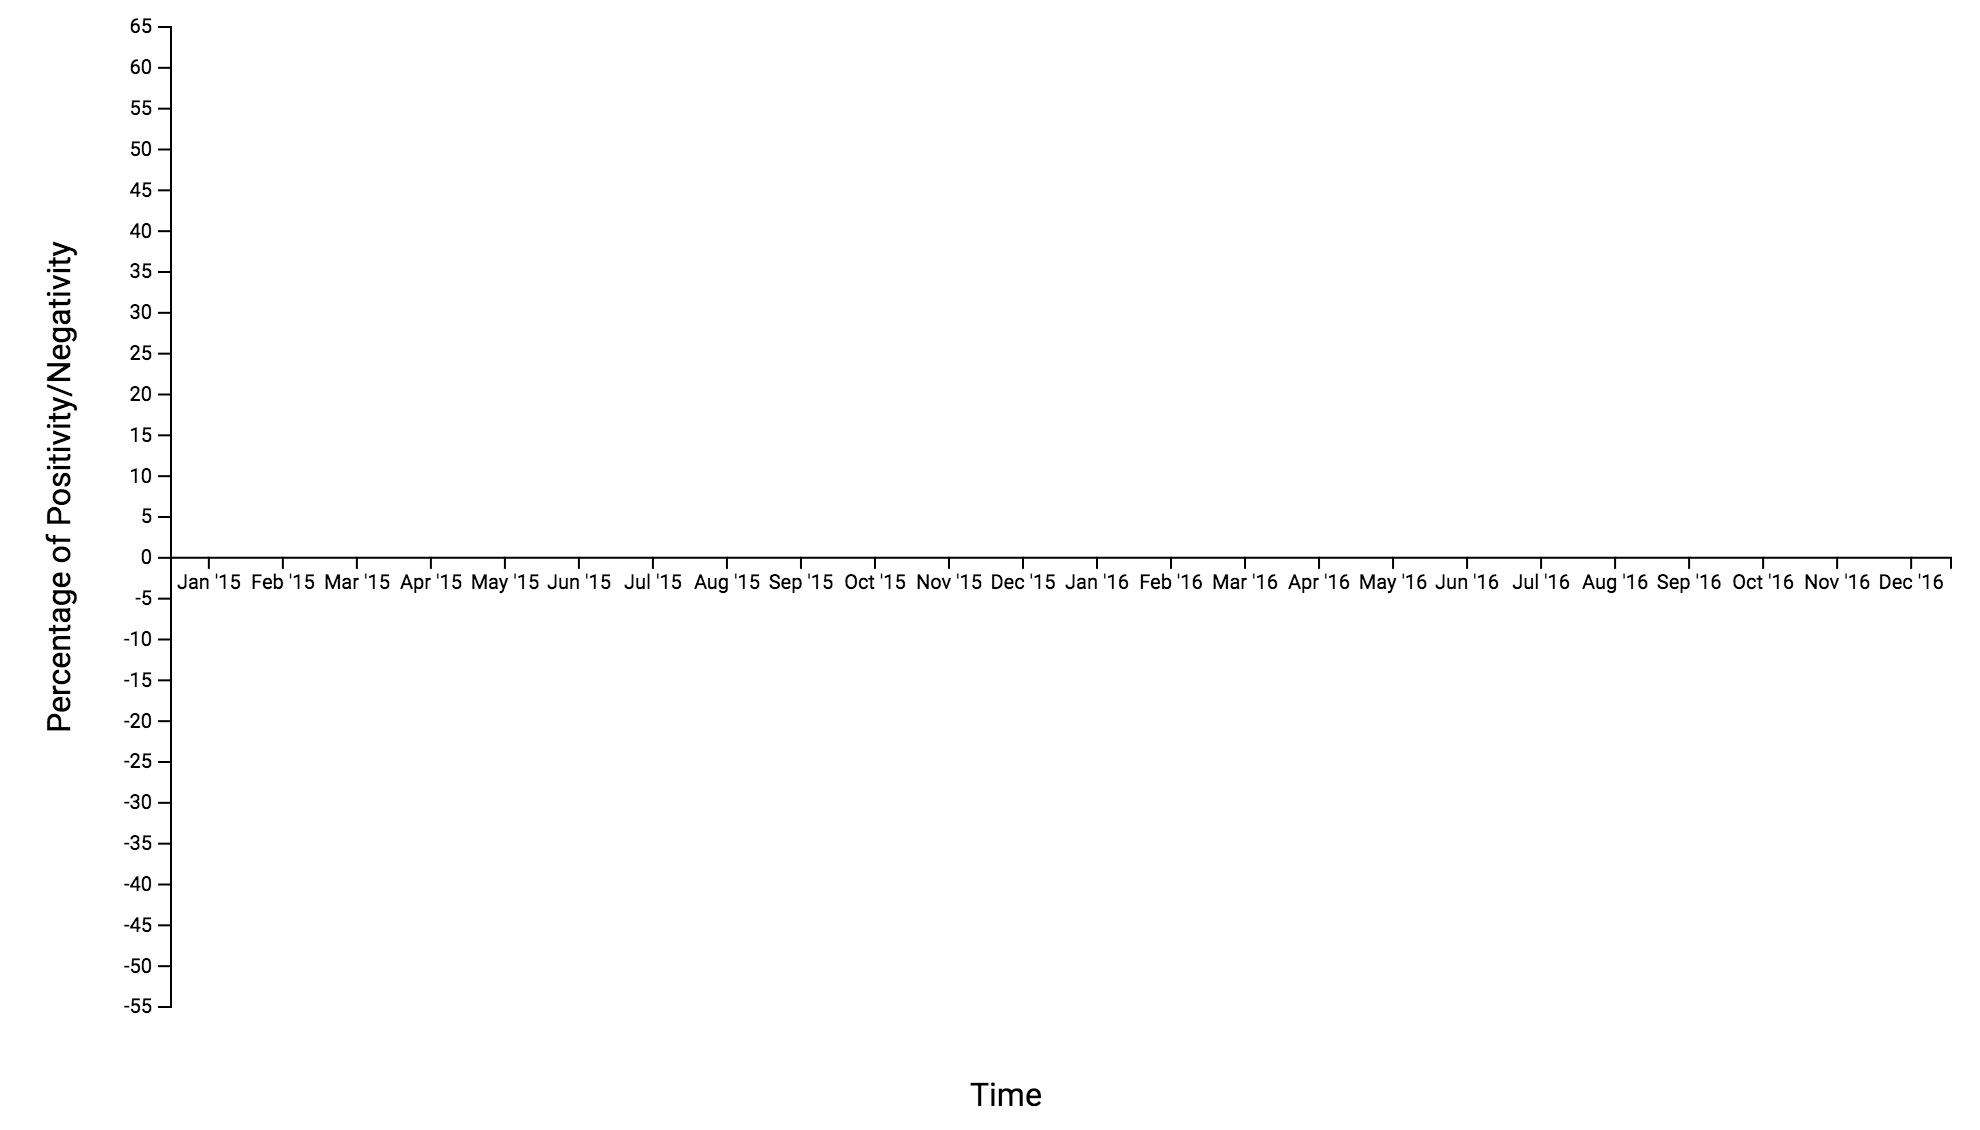

Then, I drew my rectangles in and played around with what value would get my rectangles from:

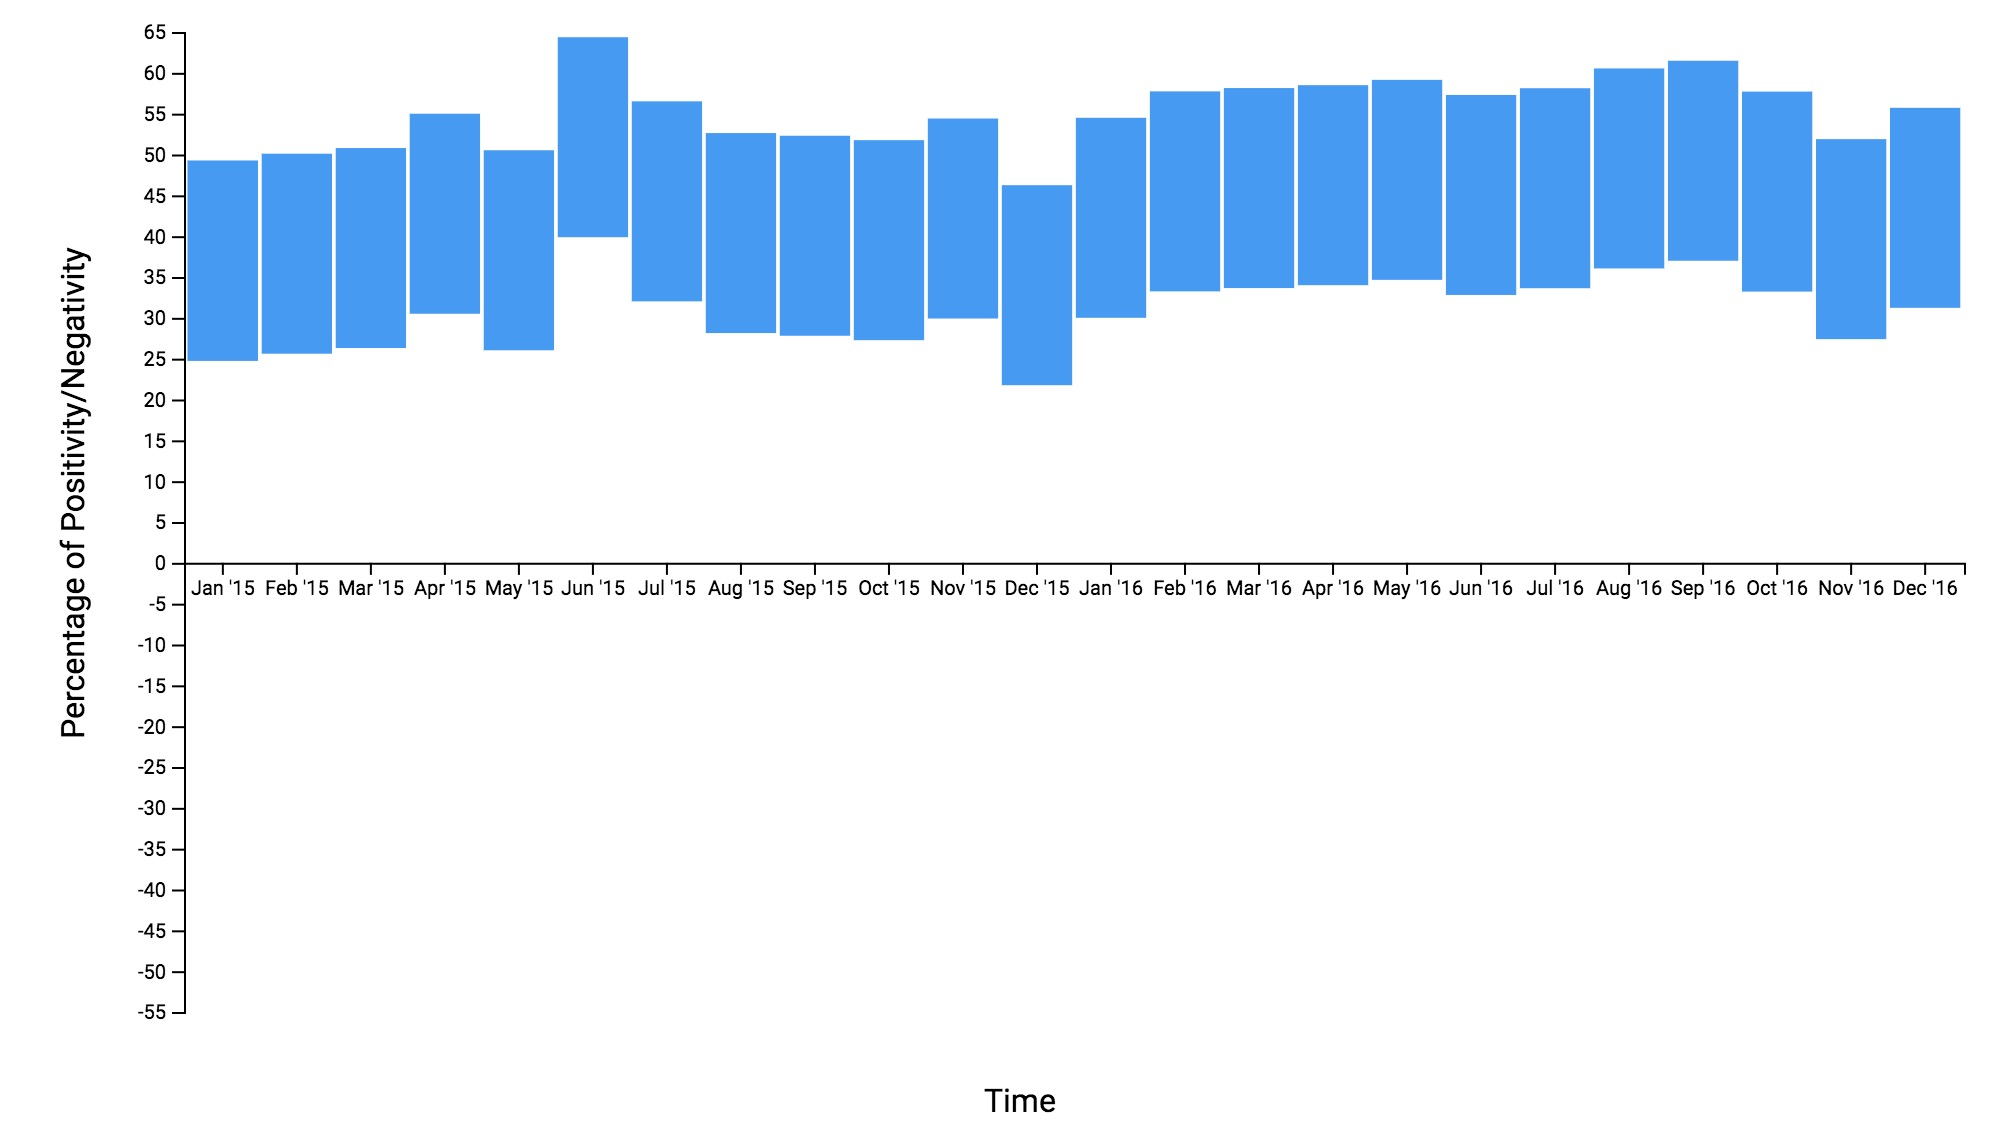

to this:

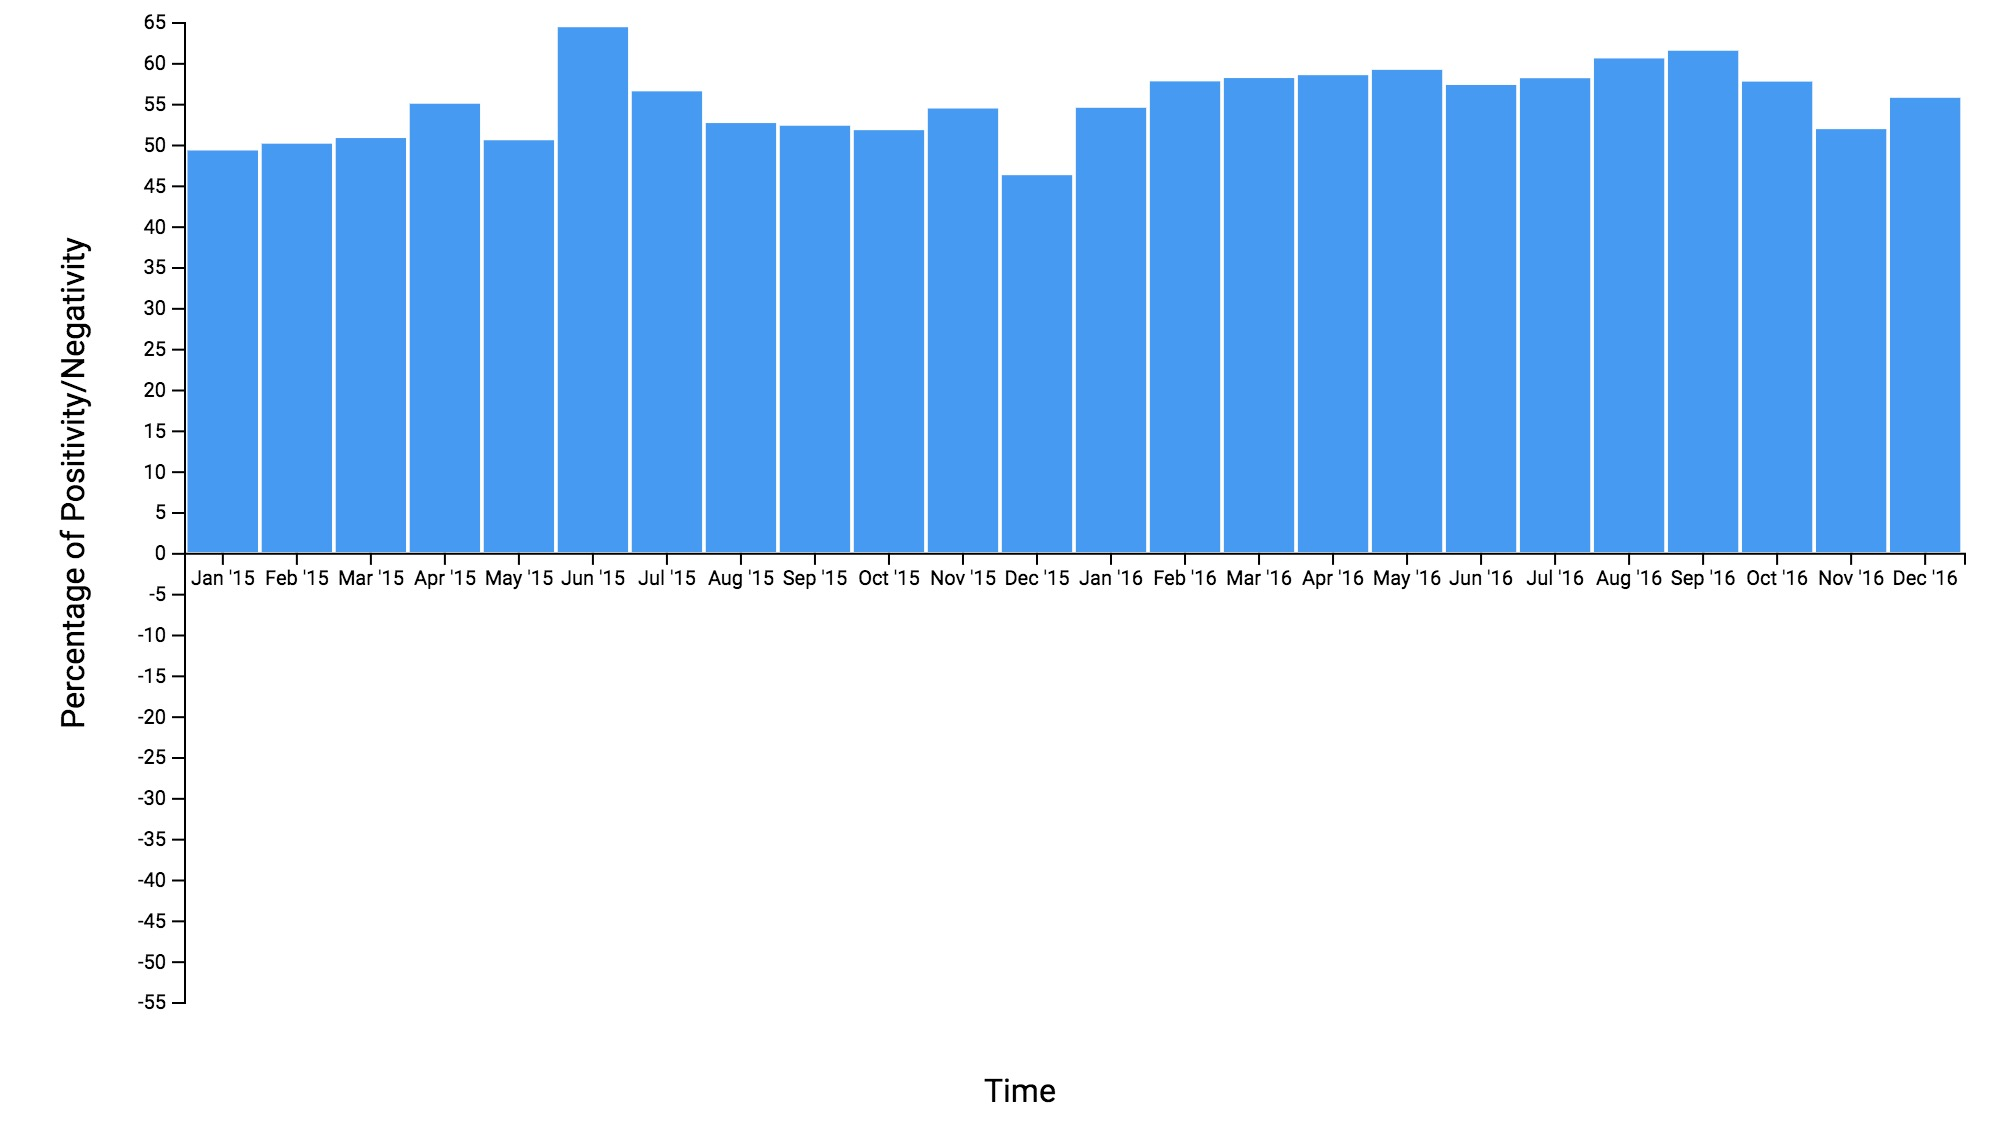

That value was 275. So, to get the bottom rectangles, I just changed the starting y value and it worked:

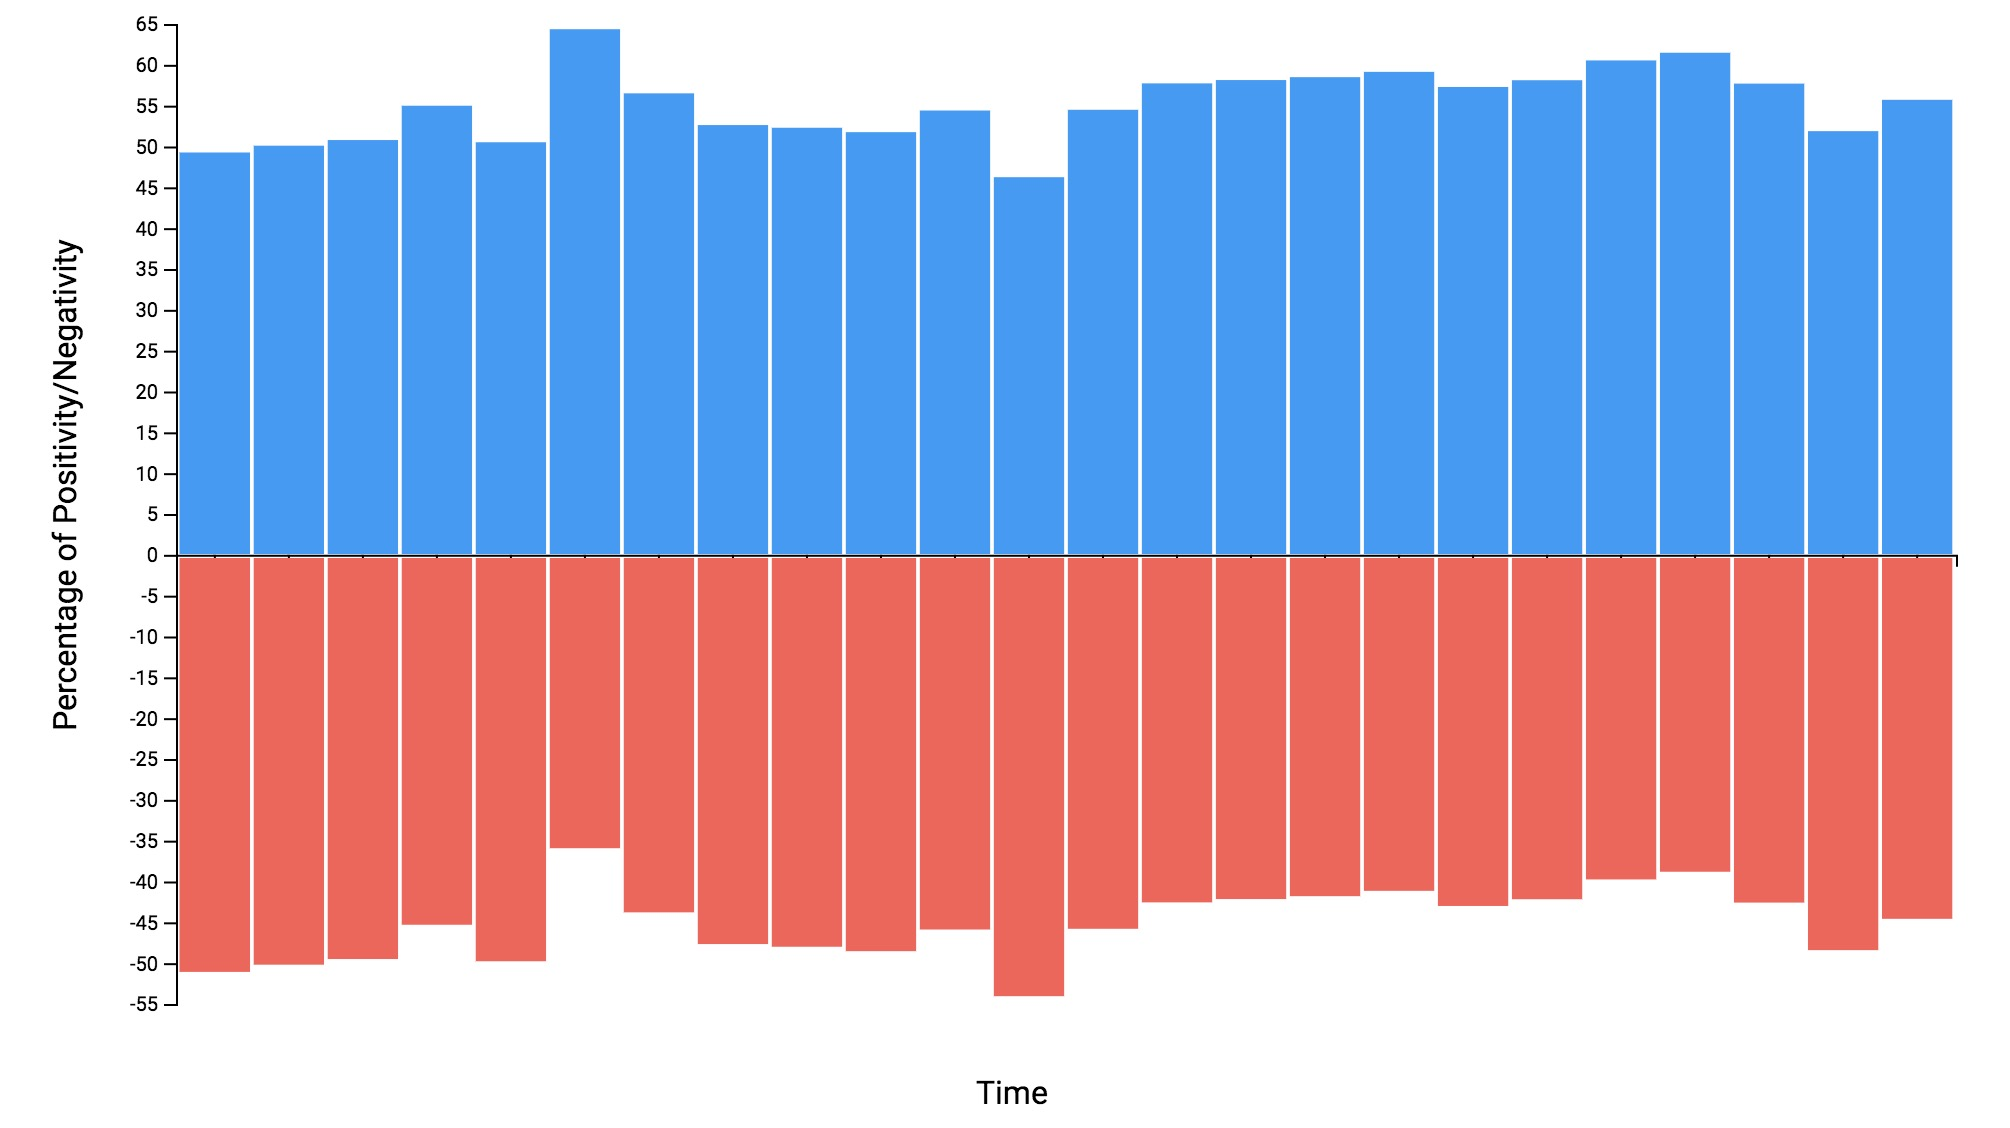

But the x axis captions were covered up, so I simply moved the x axis back down, which worked. I also readjusted the y axis values so that there's more room.

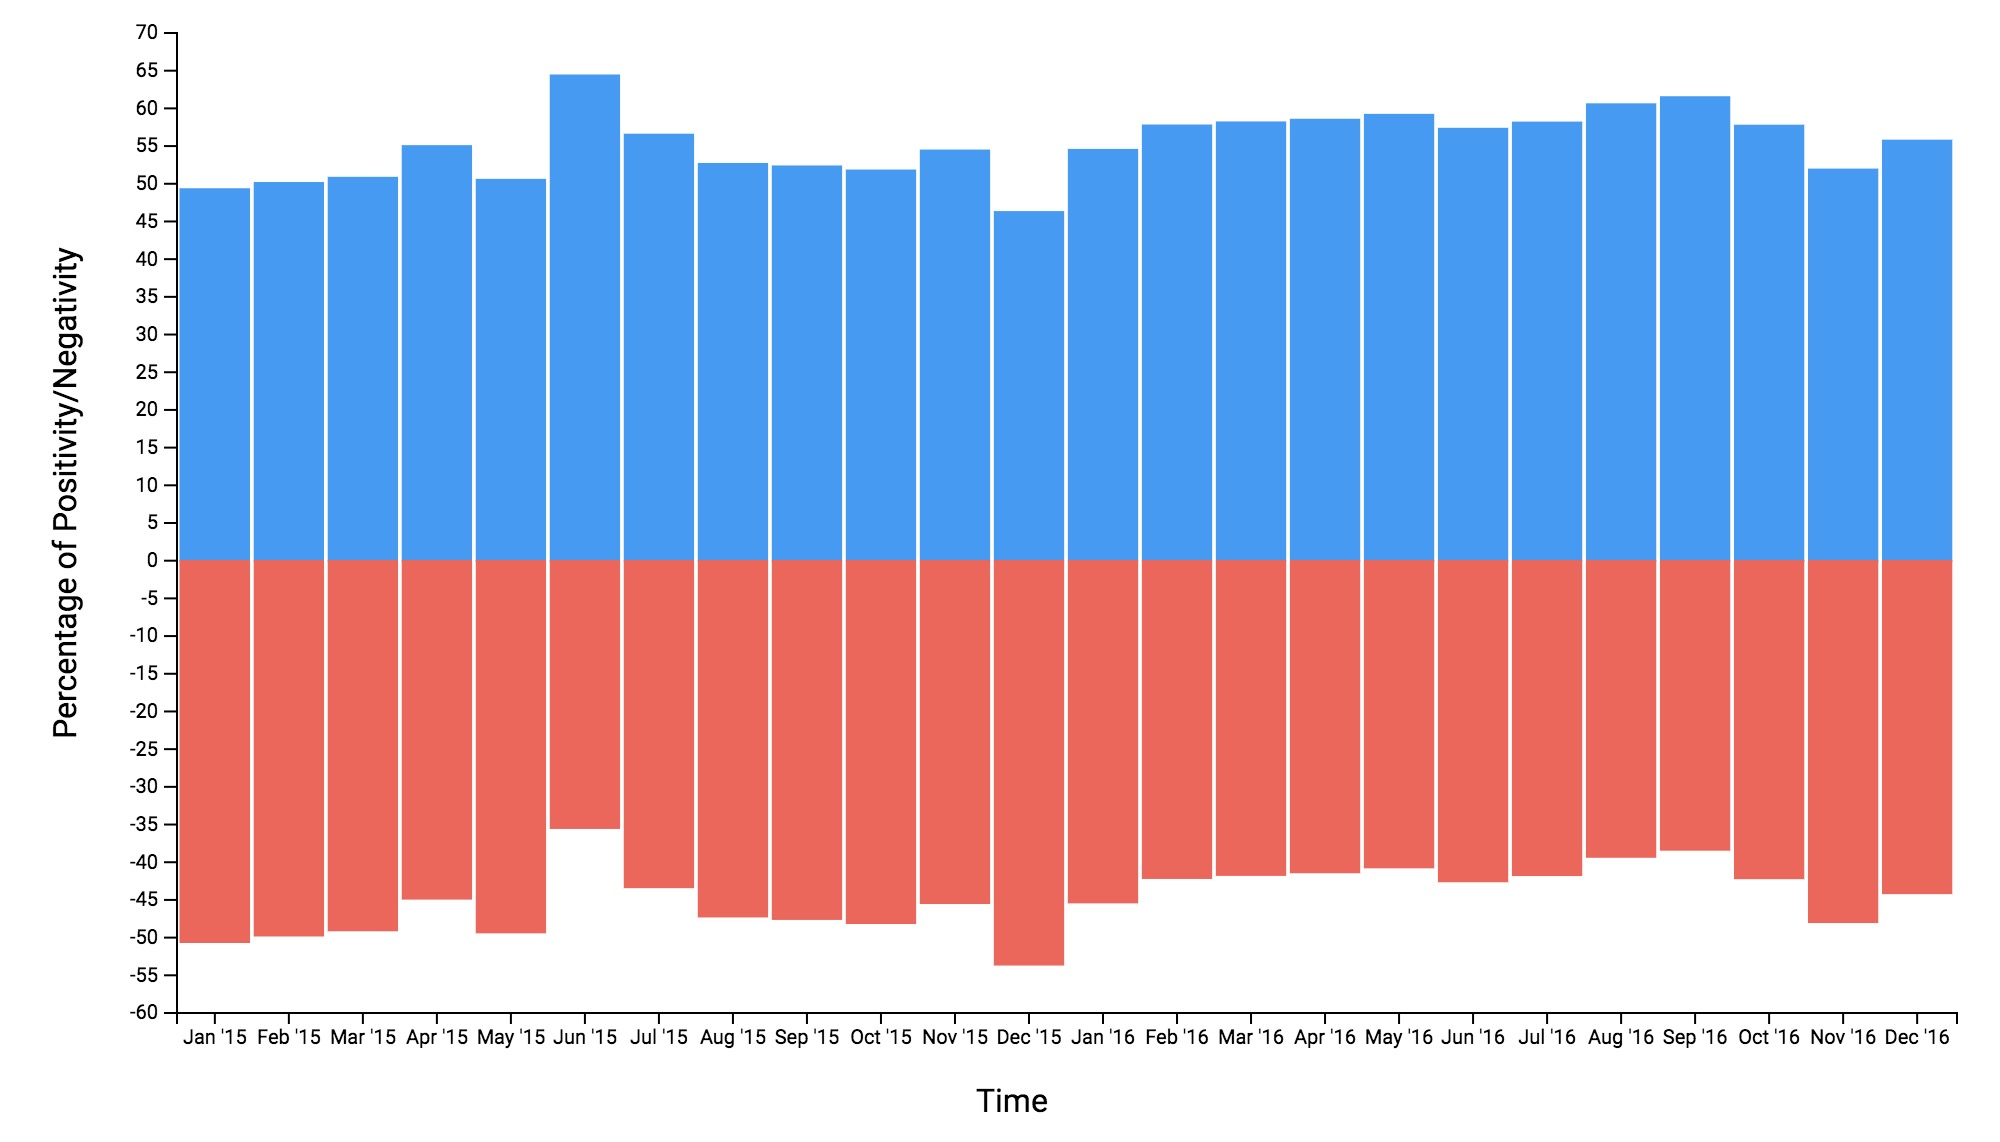